trained, tuned, and evaluated an XGBoost model

compared the performance of all three models and decided which model is best

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier, plot_importance

<ipython-input-1-286ca38ec147>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
airline_data = pd.read_csv('airline.csv')

# EDA

In [4]:
airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


In [5]:
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj

# Model Prep.

In [6]:
airline_data_dummies = pd.get_dummies(airline_data,
                                      columns = ["satisfaction", "Customer Type", "Type of Travel", "Class"])

In [7]:
y = airline_data_dummies["satisfaction_satisfied"]

x = airline_data_dummies.drop(["satisfaction_satisfied", "satisfaction_dissatisfied"], axis = 1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Model Building

In [9]:
xgb = XGBClassifier(objective = "binary:logistic", random_state = 0)

In [10]:
cv_params = {'max_depth': [4],
    'min_child_weight': [3],
    'learning_rate': [0.1],
    'n_estimators': [5],
    'subsample': [0.7],
    'colsample_bytree': [0.7]}

In [21]:
scoring = ["accuracy", "precision", "recall", "f1"]

In [22]:
xgb_cv = GridSearchCV(xgb,
                     cv_params,
                     scoring = scoring,
                     cv = 5,
                     refit = "f1"
                     )

In [23]:
%%time

xgb_cv = xgb_cv.fit(x_train, y_train)
xgb_cv

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.27 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.1],
                         'max_depth': [4], 'min_child_weight': [3],
                         'n_estimators': [5], 'subsample': [0.7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [24]:
pickle.dump(xgb_cv, open("xgb_cv.sav", "wb"))

# Results and Evaluation

In [25]:
y_pred = xgb_cv.predict(x_test)

In [26]:
ac_score = metrics.accuracy_score(y_test, y_pred)
print("the accuracy score is:", ac_score)


pc_score = metrics.precision_score(y_test, y_pred)
print("the precision score is:", pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print("the recall score is:", rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print("the f1 score is:", f1_score)

the accuracy score is: 0.8675700646750847
the precision score is: 0.8539707419017764
the recall score is: 0.9156862745098039
the f1 score is: 0.8837523655041903


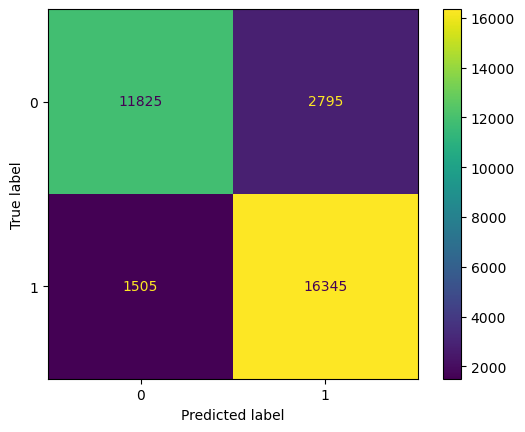

In [27]:
cm = metrics.confusion_matrix(y_test, y_pred)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                     display_labels = xgb_cv.classes_)

disp.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

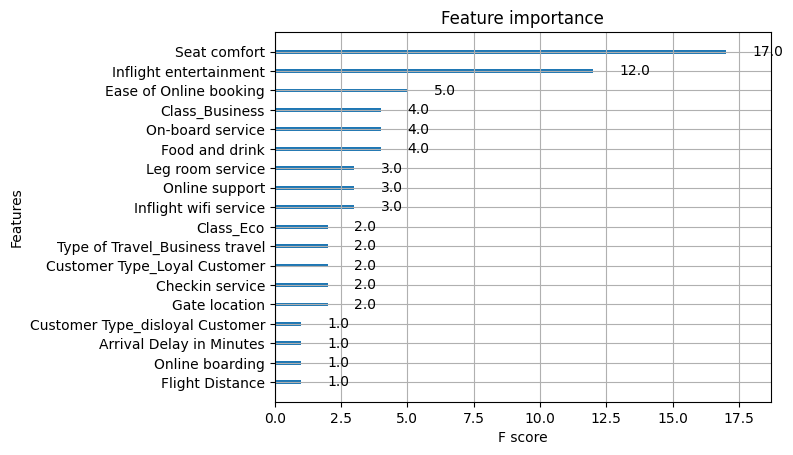

In [28]:
plot_importance(xgb_cv.best_estimator_)

In [29]:
table = pd.DataFrame({"model" : ["tunned decision tree", "tunned random forest", "tunned xgboost"],
                     "f1 score" : [0.88259, 0.947306, f1_score],
                      "recall score": [0.88672, 0.944501, rc_score],
                      "precision score" : [0.87850, 0.950128, pc_score],
                      "accuracy_score" : [0.87031, 0.942450, ac_score]
                     }
                    )
table

,model,f1 score,recall score,precision score,accuracy_score
0,tunned decision tree,0.882590,0.886720,0.878500,0.87031
1,tunned random forest,0.947306,0.944501,0.950128,0.94245
2,tunned xgboost,0.883752,0.915686,0.853971,0.86757
